In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt

# Notebook + project paths
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

from ntp_simulation import run_sim, run_batch_sim, load_params

# CSV path
csv_path = os.path.join(project_root, "data", "reactors.csv")


In [2]:
df = pd.read_csv(csv_path)
df.head()


,reactor_name,total_power_MW,inlet_temperature_K,inlet_pressure_Pa,mass_flow_kg_s,core_length_m,n_slices,area_throat_m2,area_exit_m2,inconel718_Tmax_K,cp_J_kg_K,gamma,molar_mass_kg_mol,eta_abs
0,Large_NERVA,555,300,3000000.0,12.68,1.321,100,0.0010,0.010,1000,14000,1.35,0.002,0.9
1,Pewee_1,500,300,3000000.0,10.00,1.000,100,0.0010,0.010,1000,14000,1.35,0.002,0.9
2,Phoebus_2A,4000,300,3000000.0,40.00,1.500,150,0.0020,0.020,1000,14000,1.35,0.002,0.9
3,NRX_A6,1100,300,3000000.0,15.00,1.200,120,0.0015,0.015,1000,14000,1.35,0.002,0.9
4,Particle_Bed_Reactor,1000,300,3000000.0,5.00,0.500,80,0.0008,0.008,1000,14000,1.35,0.002,0.9


In [3]:
params_path = os.path.join(project_root, "src", "params.yaml")
params = load_params(params_path)
out = run_sim(params)

# Show temperature profile
pd.DataFrame({
    "x (m)": out["x"],
    "T_gas (K)": out["T_gas"],
    "T_wall (K)": out["T_wall"]
}).head()


,x (m),T_gas (K),T_wall (K)
0,0.000000,364.285714,414.285714
1,0.052632,459.022556,509.022556
2,0.105263,584.210526,634.210526
3,0.157895,739.849624,789.849624
4,0.210526,925.939850,975.939850


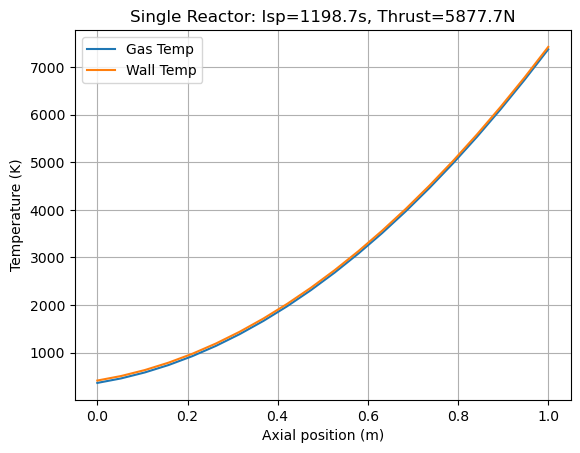

In [4]:
plt.plot(out["x"], out["T_gas"], label="Gas Temp")
plt.plot(out["x"], out["T_wall"], label="Wall Temp")
plt.xlabel("Axial position (m)")
plt.ylabel("Temperature (K)")
plt.title(f'Single Reactor: Isp={out["Isp"]:.1f}s, Thrust={out["thrust"]:.1f}N')
plt.legend()
plt.grid(True)
plt.show()


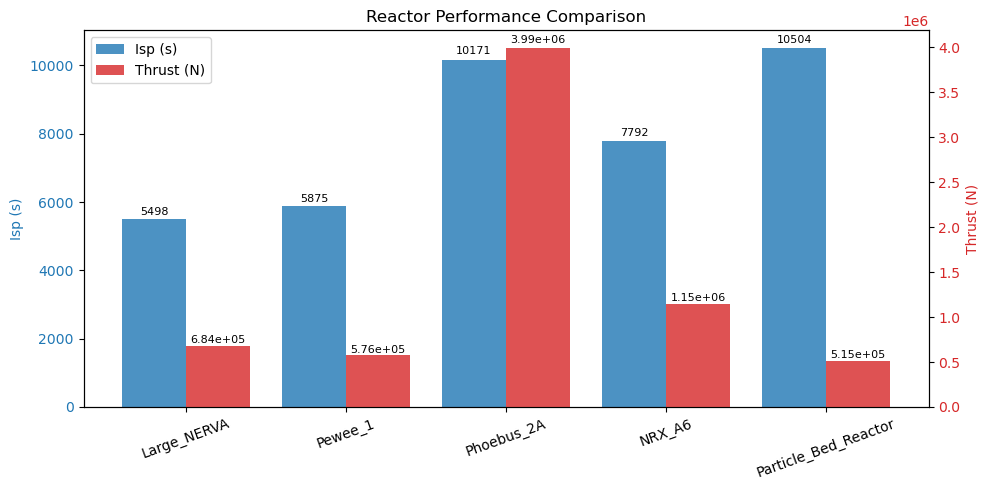

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Run batch sim to get results and summary
results, summary_df = run_batch_sim(csv_path, show_plots=False)

# Extract data
names = summary_df["reactor_name"].tolist()
Isp_values = summary_df["Isp"].tolist()
Thrust_values = summary_df["thrust"].tolist()

x = np.arange(len(names))
width = 0.4

fig, ax1 = plt.subplots(figsize=(10,5))

# Left bars = Isp
rects1 = ax1.bar(x - width/2, Isp_values, width=width, color="tab:blue", alpha=0.8)
ax1.set_ylabel("Isp (s)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Right bars = Thrust
ax2 = ax1.twinx()
rects2 = ax2.bar(x + width/2, Thrust_values, width=width, color="tab:red", alpha=0.8)
ax2.set_ylabel("Thrust (N)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Add numbers above bars
def autolabel(rects, ax, fmt="{:.0f}"):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., h + 0.01*h,
                fmt.format(h), ha="center", va="bottom", fontsize=8)

autolabel(rects1, ax1, "{:.0f}")     # Isp integer
autolabel(rects2, ax2, "{:.2e}")     # Thrust scientific notation

# X-axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(names, rotation=20)
ax1.set_title("Reactor Performance Comparison")

# ✅ Proper legend (no warnings)
handles = [rects1.patches[0], rects2.patches[0]]
labels = ["Isp (s)", "Thrust (N)"]
ax1.legend(handles, labels, loc="upper left")

fig.tight_layout()
plt.show()
